In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import datetime as dt
import pytz# add a coordinate with LocalTime for Plotting
import xarray as xr
from soslib import funcs


In [57]:
df_tilden = pd.read_parquet('../../data/tilden_tower/tilden_fluxdata_consolidated.parquet')
df_tilden = df_tilden.set_index('date')

In [77]:
# Get data for november 10th through 16th when snow appeared and disappeared
df_tilden_1110_1116_3m = df_tilden[(df_tilden.index > dt.datetime(2021,11,10)) & 
                                    (df_tilden.index < dt.datetime(2021,11,16)) & 
                                    (df_tilden['height']==3) &
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()
df_tilden_1110_1116_10m = df_tilden[(df_tilden.index > dt.datetime(2021,11,10)) & 
                                    (df_tilden.index < dt.datetime(2021,11,16)) & 
                                    (df_tilden['height']==10)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()

# Get data for november 24 to 30 when snow appeared and disappeared
df_tilden_1124_1130_3m = df_tilden[(df_tilden.index > dt.datetime(2021,11,24)) & 
                                    (df_tilden.index < dt.datetime(2021,11,30)) & 
                                    (df_tilden['height']==3)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()
df_tilden_1124_1130_10m = df_tilden[(df_tilden.index > dt.datetime(2021,11,24)) & 
                                    (df_tilden.index < dt.datetime(2021,11,30)) & 
                                    (df_tilden['height']==10)&
                                    (df_tilden['e']<=df_tilden['es'])
                                    ].replace(-999.0, np.nan).resample('1H').mean()




In [150]:
# Gather soil moisture data 
product= 'gucsebsS3.b1'
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
start_1 = '2021-11-10'
end_1 = '2021-11-16'
start_2 = '2021-11-24'
end_2 = '2021-11-30'

In [152]:
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [153]:
ds_sebs_1110_1116 = funcs.get_sail_data(username,token,product,start_1,end_1)
ds_sebs_1110_1116 = add_local_time(ds_sebs_1110_1116)

ds_sebs_1124_1130 = funcs.get_sail_data(username,token,product,start_2,end_2)
ds_sebs_1124_1130 = add_local_time(ds_sebs_1124_1130)

[DOWNLOADING] gucsebsS3.b1.20211115.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211116.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211110.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211111.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211112.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211113.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211114.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211124.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211125.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211126.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211127.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211128.000000.cdf
                             
[DOWNLOADING] gucsebsS3.b1.20211129.000000.cdf
                             

In [146]:
radsys_ds = funcs.get_daily_radsys_data('2021-11-10', '2021-11-16')
dw_solar_hourly = radsys_ds.where(radsys_ds['dw_solar_qc']==0).resample(time='1H').mean()
dw_solar_hourly = add_local_time(dw_solar_hourly)

https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21314.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21315.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21316.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21317.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21318.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21319.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21320.dat


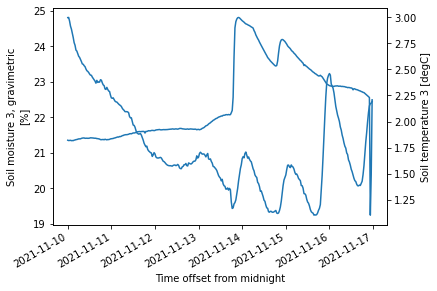

In [169]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
# ds_sebs_1110_1116['soil_temp_1'].plot(ax=ax2)
ds_sebs_1110_1116['soil_temp_3'].plot(ax=ax2)
ds_sebs_1110_1116['soil_moisture_3'].where(ds_sebs_1110_1116['qc_soil_moisture_3']==0).plot(ax=ax)
# ds_sebs_1110_1116['soil_moisture_2'].where(ds_sebs_1110_1116['qc_soil_moisture_2']==0).plot(ax=ax)

### Looking at period November 10 to 16. Snow fell first on the 10th and was gone  by the 16th. Temperature

Text(0.5, 0.98, 'Fall 2021 Storm #6 - November 10th')

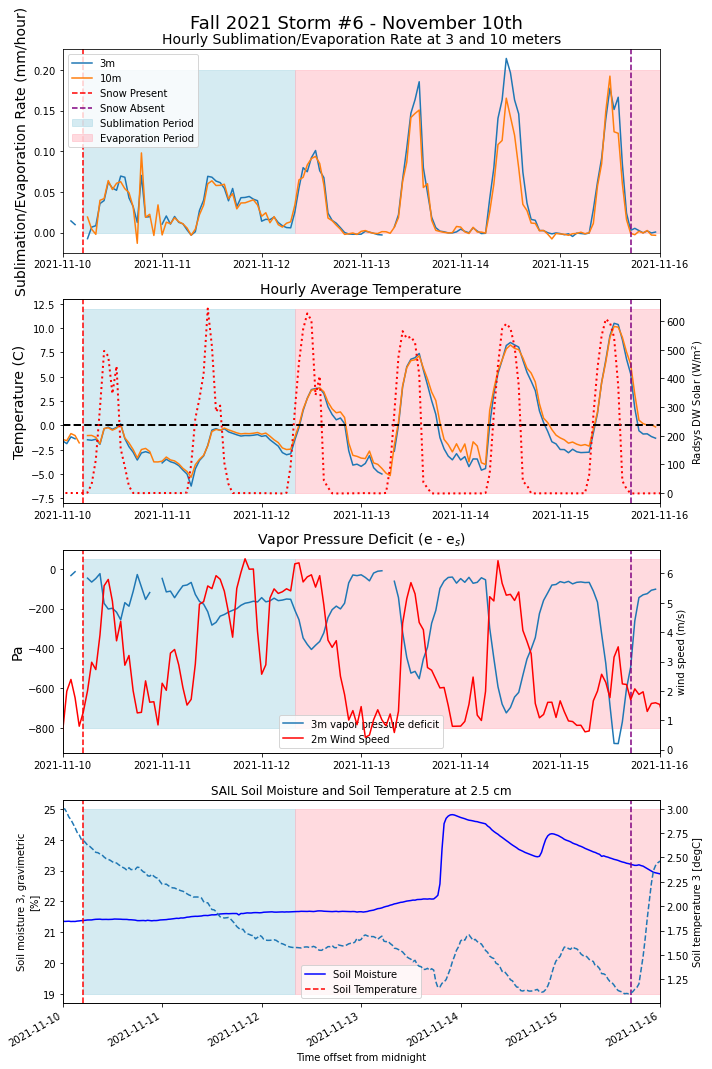

In [172]:
# Get latent heat of vaporization
Ls = 2.834e6
E_3m = df_tilden_1110_1116_3m['LE']/Ls * 3600 
E_10m = df_tilden_1110_1116_10m['LE']/Ls * 3600

fig, axs = plt.subplots(4, figsize=(10,15), tight_layout=True, facecolor='white')

# Plots for sublimation/evaporation rate
axs[0].plot(df_tilden_1110_1116_3m.index, E_3m, label='3m')
axs[0].plot(df_tilden_1110_1116_10m.index, E_10m, label='10m')

# Plots for aur tenoerature and downwelling solar radiation
axs[1].plot(df_tilden_1110_1116_3m.index, df_tilden_1110_1116_3m['Tair']-273.15, label='3m Temperature')
axs[1].plot(df_tilden_1110_1116_10m.index, df_tilden_1110_1116_10m['Tair']-273.15, label='10m Temperature')
ax1_2 = axs[1].twinx()
ax1_2.plot(dw_solar_hourly['local_time'],dw_solar_hourly['dw_solar'], color = 'red', ls='dotted', lw=2)
ax1_2.set_ylabel('Radsys DW Solar (W/m$^2$)')
axs[1].axhline(0, ls='--', color='k', lw=2)

# Plots for vapor pressure deficit and wind speed
axs[2].plot(df_tilden_1110_1116_3m.index, (df_tilden_1110_1116_3m['e'] - df_tilden_1110_1116_3m['es']), label='3m vapor pressure deficit')
ax3 = axs[2].twinx()
ax3.plot(dw_solar_hourly['local_time'],dw_solar_hourly['WindSpd'], color='red')
ax3.set_ylabel('wind speed (m/s)')
axs[2].plot([],[], color='red', label='2m Wind Speed')
axs[2].legend()

# Plots for soil moisture and soil temperature
ax3_2 = axs[3].twinx()
ds_sebs_1110_1116['soil_temp_3'].plot(ax=ax3_2, label='Soil Temperautre', ls='--', color='r')
ds_sebs_1110_1116['soil_moisture_3'].where(ds_sebs_1110_1116['qc_soil_moisture_3']==0).plot(ax=axs[3], label='Soil Moisture',color='blue')
axs[3].plot([],[],label='Soil Temperature', ls='--', color='r')
axs[3].legend()

y_ranges = [[0,0.2],[-7,12],[-800,50],[19,25]]
for i,ax in enumerate(axs):
    ax.axvline(dt.datetime(2021,11,10,5), label='Snow Present', ls='--', color='red')
    ax.axvline(dt.datetime(2021,11,15,17), label='Snow Absent', ls='--', color='purple')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,10,5),
                                  dt.datetime(2021,11,12,8), 
                                  label='Sublimation Period', 
                                  alpha=0.5, 
                                  color='lightblue')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,12,8),
                                  dt.datetime(2021,11,16,0), 
                                  label='Evaporation Period', 
                                  alpha=0.5,
                                  color='lightpink')
    if i ==0:
        ax.legend()
    ax.set_xlim(dt.datetime(2021,11,10), dt.datetime(2021,11,16,0))

axs[0].set_ylabel('Sublimation/Evaporation Rate (mm/hour)', size=14)
axs[0].set_title('Hourly Sublimation/Evaporation Rate at 3 and 10 meters', size=14)

axs[1].set_title('Hourly Average Temperature', size=14)
axs[1].set_ylabel('Temperature (C)', size=14)

axs[2].set_title('Vapor Pressure Deficit (e - e$_s$)', size=14)
axs[2].set_ylabel('Pa', size=14)

axs[3].set_title('SAIL Soil Moisture and Soil Temperature at 2.5 cm')
fig.suptitle('Fall 2021 Storm #6 - November 10th', size=18)

In [181]:
radsys_ds = funcs.get_daily_radsys_data('2021-11-24', '2021-11-30')
dw_solar_hourly = radsys_ds.where(radsys_ds['dw_solar_qc']==0).resample(time='1H').mean()
dw_solar_hourly = add_local_time(dw_solar_hourly)

https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21328.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21329.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21330.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21331.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21332.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21333.dat
https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp21334.dat


Text(0.5, 0.98, 'Fall 2021 Storm #10 - November 23-24th')

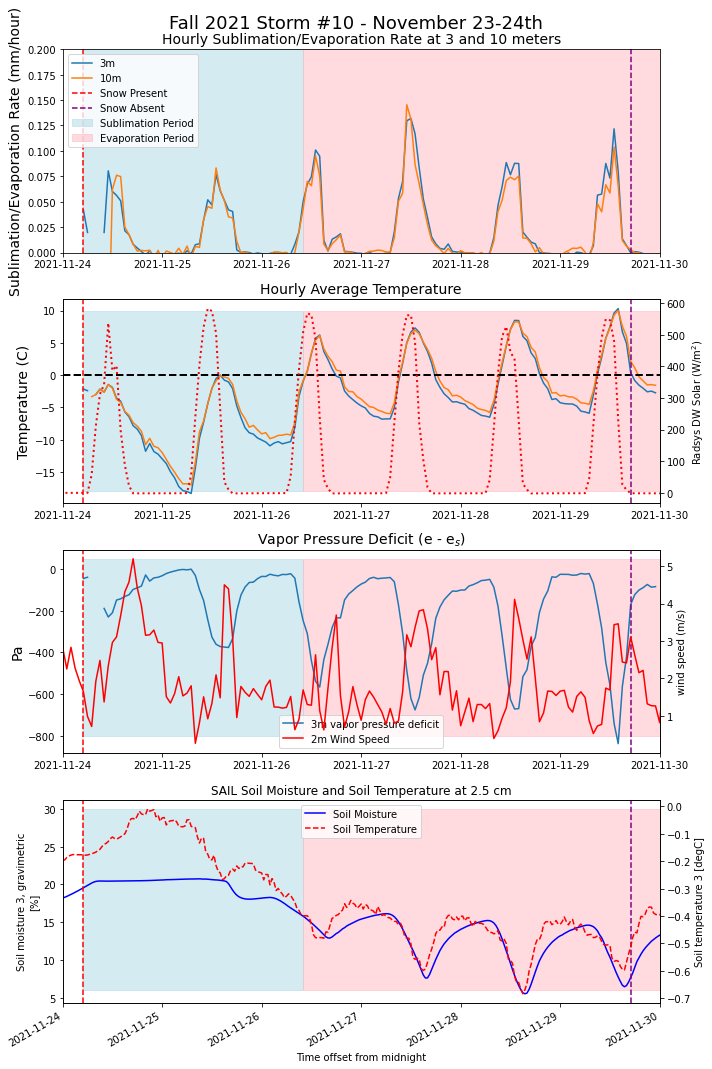

In [182]:
# Get latent heat of vaporization
Ls = 2.834e6
E_3m = df_tilden_1124_1130_3m['LE']/Ls * 3600 
E_10m = df_tilden_1124_1130_10m['LE']/Ls * 3600

fig, axs = plt.subplots(4, figsize=(10,15), tight_layout=True, facecolor='white')

# Plots for sublimation/evaporation rate
axs[0].plot(df_tilden_1124_1130_3m.index, E_3m, label='3m')
axs[0].plot(df_tilden_1124_1130_10m.index, E_10m, label='10m')

# Plots for air temperature and solar radiation
axs[1].plot(df_tilden_1124_1130_3m.index, df_tilden_1124_1130_3m['Tair']-273.15, label='3m Temperature')
axs[1].plot(df_tilden_1124_1130_10m.index, df_tilden_1124_1130_10m['Tair']-273.15, label='10m Temperature')
ax1_2 = axs[1].twinx()
ax1_2.plot(dw_solar_hourly['local_time'],dw_solar_hourly['dw_solar'], color = 'red', ls='dotted', lw=2)
ax1_2.set_ylabel('Radsys DW Solar (W/m$^2$)')
axs[1].axhline(0, ls='--', color='k', lw=2)

# Plots for vapor pressure deficit and wind speed
axs[2].plot(df_tilden_1124_1130_3m.index, (df_tilden_1124_1130_3m['e'] - df_tilden_1124_1130_3m['es']), label='3m vapor pressure deficit')
ax2_3 = axs[2].twinx()
ax2_3.plot(dw_solar_hourly['local_time'],dw_solar_hourly['WindSpd'], color='red')
ax2_3.set_ylabel('wind speed (m/s)')
axs[2].plot([],[], color='red', label='2m Wind Speed')
axs[2].legend()

# Plots for soil moisture and soil temperature
ax3_2 = axs[3].twinx()
ds_sebs_1124_1130['soil_temp_3'].plot(ax=ax3_2, label='Soil Temperautre', ls='--', color='r')
ds_sebs_1124_1130['soil_moisture_3'].where(ds_sebs_1124_1130['qc_soil_moisture_3']==0).plot(ax=axs[3], label='Soil Moisture',color='blue')
axs[3].plot([],[],label='Soil Temperature', ls='--', color='r')
axs[3].legend()

y_ranges = [[0,0.2],[-18,10],[-800,50],[6,30]]
for i,ax in enumerate(axs):
    ax.axvline(dt.datetime(2021,11,24,5), label='Snow Present', ls='--', color='red')
    ax.axvline(dt.datetime(2021,11,29,17), label='Snow Absent', ls='--', color='purple')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,24,5),
                                  dt.datetime(2021,11,26,10), 
                                  label='Sublimation Period', 
                                  alpha=0.5, 
                                  color='lightblue')
    ax.fill_betweenx(y_ranges[i], dt.datetime(2021,11,26,10),
                                  dt.datetime(2021,11,30,0), 
                                  label='Evaporation Period', 
                                  alpha=0.5,
                                  color='lightpink')
    if i ==0:
        ax.legend()
        ax.set_ylim(0,0.2)
    ax.set_xlim(dt.datetime(2021,11,24), dt.datetime(2021,11,30,0))

axs[0].set_ylabel('Sublimation/Evaporation Rate (mm/hour)', size=14)
axs[0].set_title('Hourly Sublimation/Evaporation Rate at 3 and 10 meters', size=14)

axs[1].set_title('Hourly Average Temperature', size=14)
axs[1].set_ylabel('Temperature (C)', size=14)

axs[2].set_title('Vapor Pressure Deficit (e - e$_s$)', size=14)
axs[2].set_ylabel('Pa', size=14)

axs[3].set_title('SAIL Soil Moisture and Soil Temperature at 2.5 cm')
fig.suptitle('Fall 2021 Storm #10 - November 23-24th', size=18)